In [3]:
import torch
import rbm
import h5py

# CHOOSE CPU OR GPU
# device = torch.device("cpu") 
device = torch.device("cuda:0")
dtype = torch.float

# Load DATASET
import numpy as np
import matplotlib.pyplot as plt

path_dset = '../../TorchRBM.py/dataset/'
# randomize the dataset
X = torch.tensor(np.genfromtxt(path_dset+'10K_SNP_1000G_real.hapt')[:,2:].T).float().to(device)
X = X[:,torch.randperm(X.shape[1])]

Nv = X.shape[0]
Ns = X.shape[1]
print('NumSamples=',Ns)
print('ShapeX : ',X.shape)

NumSamples= 5008
ShapeX :  torch.Size([10000, 5008])


In [4]:
# Some scatter plots of the dataset
u,s,v = torch.svd(X)
ScatX = (X.T @ u).cpu()

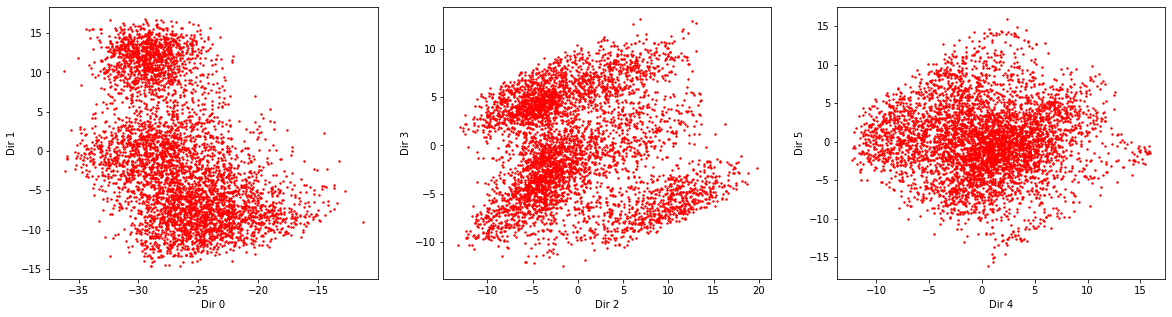

In [5]:
# Scatter plots on the first 6 directions
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i in range(3):
    ax[i].scatter(ScatX[:,2*i],ScatX[:,2*i+1],s=2,color='red')
    ax[i].set_xlabel('Dir '+str(2*i))
    ax[i].set_ylabel('Dir '+str(2*i+1))

### Investigating the behavior of the RBM at various epochs

In [6]:
# fname = 'RBMTrainingGene10K_OOELearning_Nh1000_lr0.01_l20.0_Rdm_NGibbs50.h5'
fname = 'RBMTrainingGene10K_OOELearning_Nh2000_lr0.001_l20.0_Rdm_NGibbs50.h5'
f = h5py.File(fname,'r')
Nh = f['Nh'][()]
Nv = f['Nv'][()]
l2 = f['l2'][()]
NGibbs = f['NGibbs'][()]

In [7]:
# Creating Object RBM
RBMGene = rbm.RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				regL2=l2,
				gibbs_steps=NGibbs,
				UpdCentered=True)

In [8]:
# Loading the last epoch
ep_last = f['alltime'][:][-1]
print('Ep=',ep_last)
RBMGene.W = torch.tensor(f['W_'+str(ep_last)][:]).to(device)
RBMGene.vbias = torch.tensor(f['vbias_'+str(ep_last)][:]).to(device)
RBMGene.hbias = torch.tensor(f['hbias_'+str(ep_last)][:]).to(device)

Ep= 100001


In [9]:
# Generate new samples
NS = 1000
vinit = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
vs,vm,_,_ = RBMGene.Sampling(vinit,it_mcmc=NGibbs)

In [10]:
AG_Scat = (vs.T @ u).cpu()

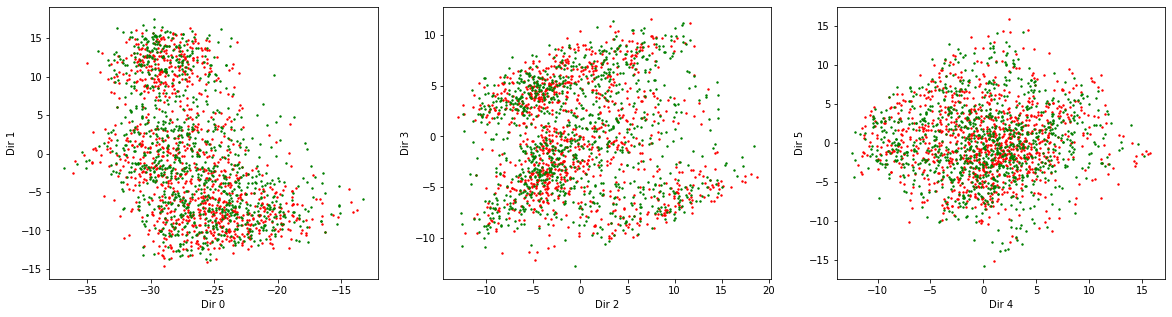

In [11]:
# Scatter plots on the first 6 directions
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i in range(3):
    ax[i].scatter(ScatX[:NS,2*i],ScatX[:NS,2*i+1],s=2,color='red')
    ax[i].scatter(AG_Scat[:,2*i],AG_Scat[:,2*i+1],s=2,color='green')
    ax[i].set_xlabel('Dir '+str(2*i))
    ax[i].set_ylabel('Dir '+str(2*i+1))

In [12]:
# Check AATS in time

TMax = 1000
Δt = 5
Nmsr = TMax//Δt+1
AATS_MCMC = torch.zeros(Nmsr,2)
T_TOT = 0

vs = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
idx_t = 0
AATS_MCMC[idx_t,0],AATS_MCMC[idx_t,1] = RBMGene.ComputeAATS(X[:,torch.randperm(X.size()[1])[:NS]],vs,NS)

while(T_TOT<TMax):
    vs,vm,_,_ = RBMGene.Sampling(vs,it_mcmc=Δt)
    idx_t += 1
    T_TOT += Δt
    AATS_MCMC[idx_t,0],AATS_MCMC[idx_t,1] = RBMGene.ComputeAATS(X[:,:NS],vs,NS)

<ipython-input-13-39c1c7d6fe50>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_xlim(0,TMax)


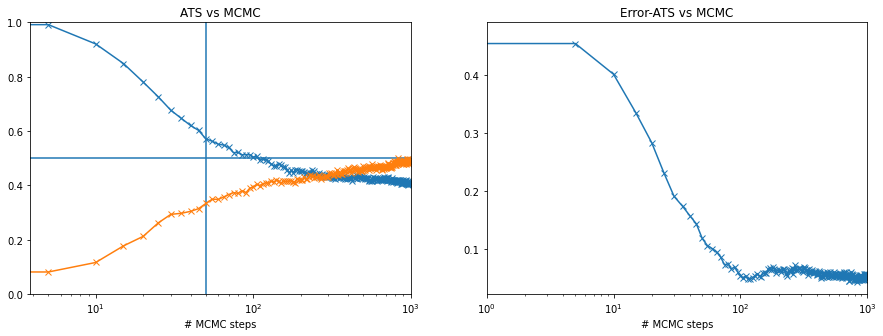

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].semilogx(np.arange(0,TMax+1,Δt),AATS_MCMC,'x-')
ax[0].vlines(50,0,1)
ax[0].hlines(0.5,0,TMax)
ax[0].set_xlim(0,TMax)
ax[1].set_xlim(1,TMax)
ax[0].set_ylim(0,1)
ax[0].set_title('ATS vs MCMC')
ax[0].set_xlabel('# MCMC steps')
ax[1].set_title('Error-ATS vs MCMC')
ax[1].set_xlabel('# MCMC steps')
ax[1].semilogx(np.arange(0,TMax+1,Δt),0.5*np.abs(AATS_MCMC-0.5).sum(1),'x-')

In [14]:
# Eigenvalues and AATS (@NGibbs)
NEp = f['alltime'].shape[0]
eigens = torch.zeros(NEp,min(100,Nh))
LIKE = torch.zeros(NEp)
AATS = torch.zeros(NEp,2)

# Choose NGibbs=35
NGibbs_GEN = 200

for i in np.arange(NEp):
    ep = f['alltime'][i]
    RBMGene.W = torch.tensor(f['W_'+str(ep)][:]).to(device)
    RBMGene.vbias = torch.tensor(f['vbias_'+str(ep)][:]).to(device)
    RBMGene.hbias = torch.tensor(f['hbias_'+str(ep)][:]).to(device)
    
    # Compute eigenvalues
    _,s,_ = torch.svd(RBMGene.W)
    eigens[i,:] = s[:100].cpu()
    
    # Generate samples
    vinit = torch.bernoulli(torch.rand((Nv,NS), device=RBMGene.device, dtype=RBMGene.dtype))
    vs,vm,_,_ = RBMGene.Sampling(vinit,it_mcmc=NGibbs_GEN)
    
    # Compute AATS
    AATS[i,0],AATS[i,1] = RBMGene.ComputeAATS(X[:,torch.randperm(X.size()[1])[:NS]],vs,NS)
    
    # Compute Likelihood
    FreeEnergyLIKE = -torch.mean(RBMGene.FreeEnergy(X))
    LIKE[i] = FreeEnergyLIKE-f['FE_AIS_'+str(ep)][()]*(Nv+Nh)

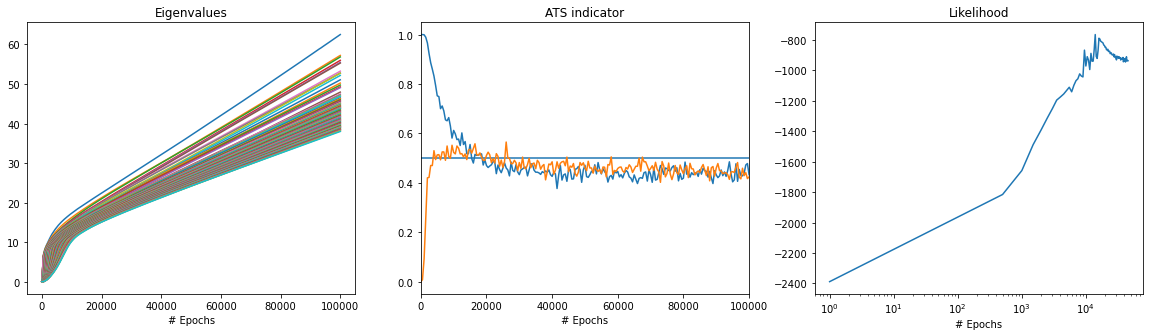

In [15]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].plot(f['alltime'],eigens);
ax[1].plot(f['alltime'],AATS);
ax[1].hlines(0.5,0,f['alltime'][-1])
ax[1].set_xlim(0,f['alltime'][-1])
ax[2].semilogx(f['alltime'],LIKE)

ax[0].set_title('Eigenvalues')
ax[1].set_title('ATS indicator')
ax[2].set_title('Likelihood')
for i in range(3):
    ax[i].set_xlabel('# Epochs')